<a href="https://colab.research.google.com/github/Amiya-Kalita/Machine-Learning/blob/main/Time_series_Wikly_fuel_Price_pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### This is a  project that forecasts EURO-SUPER 95 fuel prices using multiple time series techniques and machine learning algorithms.

### Step 1 : Import Libaries and Load Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [2]:
# for time series decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf , plot_pacf

In [3]:
# for machine learning
from sklearn.model_selection import train_test_split , TimeSeriesSplit , GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge , Lasso
from sklearn.ensemble import RandomForestRegressor , GradientBoostingRegressor
from sklearn.metrics import mean_squared_error , mean_absolute_error , r2_score
from sklearn.pipeline import Pipeline

In [4]:
df = pd.read_csv('/content/drive/MyDrive/DataSets/weekly_fuel_prices_from_2005_to_20240419.csv')
print("Dataset shape :" , df.shape)
print("\nFirst 5 rows :")
print(df.head())
print("\nDataset info :")
print(df.info())
print("\nBasic Statistics :")
print(df.describe())

Dataset shape : (969, 9)

First 5 rows :
  SURVEY_DATE  EURO-SUPER_95  AUTOMOTIVE_GAS_OIL     LPG  METHANE  LNG  \
0  2005-01-03        1115.75             1018.28  552.50        0    0   
1  2005-01-10        1088.00             1004.39  552.57        0    0   
2  2005-01-17        1088.14             1004.31  551.88        0    0   
3  2005-01-24        1090.01             1004.31  551.88        0    0   
4  2005-01-31        1132.11             1022.60  551.88        0    0   

   HEATING_GAS_OIL  RESIDUAL_FUEL_OIL  HEAVY_FUEL_OIL  
0           948.50             553.25          229.52  
1           947.94             554.22          238.37  
2           952.42             562.78          245.89  
3           963.98             573.42          243.84  
4           972.95             579.23          242.53  

Dataset info :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 969 entries, 0 to 968
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ----

### Step 2: Data Preprocessing

In [5]:
# converting Survey_date to datetime format
df['SURVEY_DATE'] = pd.to_datetime(df['SURVEY_DATE'])

# sort by date the SURVEY_DATE column
df = df.sort_values('SURVEY_DATE').reset_index(drop = True)

In [6]:
df.head()

,SURVEY_DATE,EURO-SUPER_95,AUTOMOTIVE_GAS_OIL,LPG,METHANE,LNG,HEATING_GAS_OIL,RESIDUAL_FUEL_OIL,HEAVY_FUEL_OIL
0,2005-01-03,1115.75,1018.28,552.50,0,0,948.50,553.25,229.52
1,2005-01-10,1088.00,1004.39,552.57,0,0,947.94,554.22,238.37
2,2005-01-17,1088.14,1004.31,551.88,0,0,952.42,562.78,245.89
3,2005-01-24,1090.01,1004.31,551.88,0,0,963.98,573.42,243.84
4,2005-01-31,1132.11,1022.60,551.88,0,0,972.95,579.23,242.53


In [8]:
# finding missing values in the dataset
print("Missing Values :\n")
print(df.isnull().sum())

Missing Values :

SURVEY_DATE           0
EURO-SUPER_95         0
AUTOMOTIVE_GAS_OIL    0
LPG                   0
METHANE               0
LNG                   0
HEATING_GAS_OIL       0
RESIDUAL_FUEL_OIL     0
HEAVY_FUEL_OIL        0
dtype: int64


In [10]:
# focus on (EURO-super_95 for forecasting) <---------- Target variable
# Creating a simplified dataframe
fuel_df = df[['SURVEY_DATE' , 'EURO-SUPER_95']].copy()
fuel_df.columns = ['Date' , 'Price']

# Setting Date as Index
fuel_df.set_index('Date' , inplace = True)

In [11]:
print("\nFuel Price Dataset :")
print(fuel_df.head())
print("\nData Range :" , fuel_df.index.min() , "to" , fuel_df.index.max())
print("Total Records :" , len(fuel_df))


Fuel Price Dataset :
              Price
Date               
2005-01-03  1115.75
2005-01-10  1088.00
2005-01-17  1088.14
2005-01-24  1090.01
2005-01-31  1132.11

Data Range : 2005-01-03 00:00:00 to 2024-04-15 00:00:00
Total Records : 969


### Step 3 : Exploratory Data Analysis (EDA)

#### 3.1 Vitualize Time Series

In [15]:
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

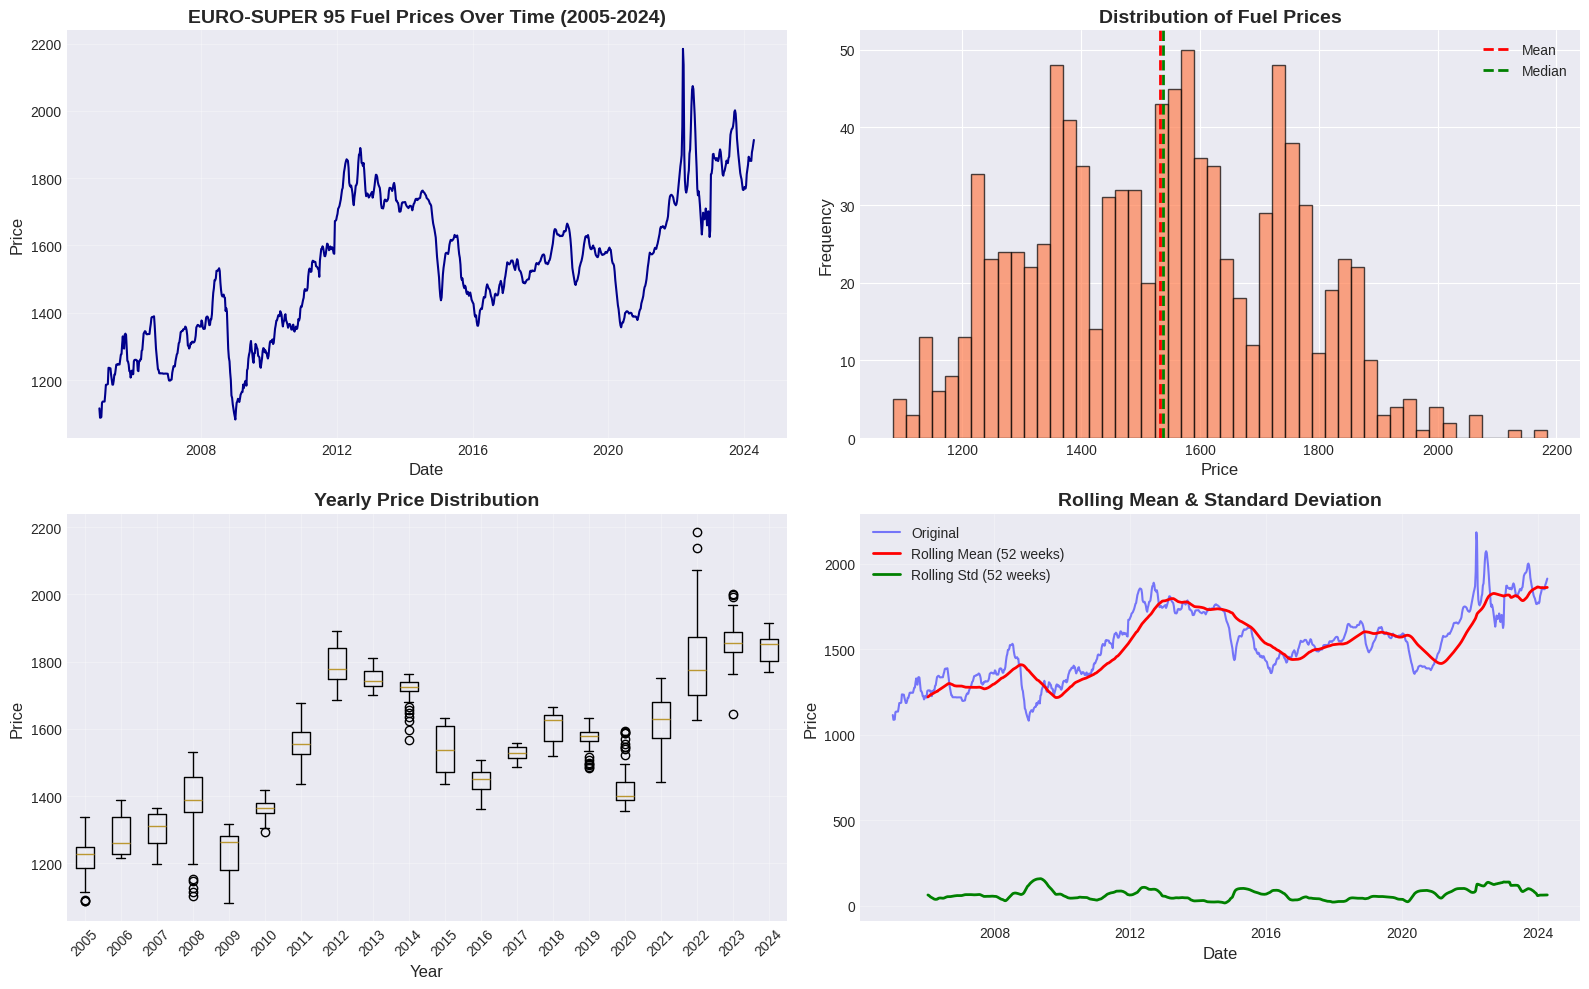

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Plot 1: Complete time series
axes[0, 0].plot(fuel_df.index, fuel_df['Price'], color='darkblue', linewidth=1.5)
axes[0, 0].set_title('EURO-SUPER 95 Fuel Prices Over Time (2005-2024)', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Date', fontsize=12)
axes[0, 0].set_ylabel('Price', fontsize=12)
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Distribution of prices
axes[0, 1].hist(fuel_df['Price'], bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Distribution of Fuel Prices', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Price', fontsize=12)
axes[0, 1].set_ylabel('Frequency', fontsize=12)
axes[0, 1].axvline(fuel_df['Price'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')
axes[0, 1].axvline(fuel_df['Price'].median(), color='green', linestyle='--', linewidth=2, label='Median')
axes[0, 1].legend()

# Plot 3: Boxplot by year
fuel_df_copy = fuel_df.copy()
fuel_df_copy['Year'] = fuel_df_copy.index.year
yearly_data = [fuel_df_copy[fuel_df_copy['Year'] == year]['Price'].values
               for year in sorted(fuel_df_copy['Year'].unique())]
axes[1, 0].boxplot(yearly_data, labels=sorted(fuel_df_copy['Year'].unique()))
axes[1, 0].set_title('Yearly Price Distribution', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Year', fontsize=12)
axes[1, 0].set_ylabel('Price', fontsize=12)
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Rolling statistics
rolling_mean = fuel_df['Price'].rolling(window=52).mean()  # 52 weeks = 1 year
rolling_std = fuel_df['Price'].rolling(window=52).std()
axes[1, 1].plot(fuel_df.index, fuel_df['Price'], color='blue', alpha=0.5, label='Original')
axes[1, 1].plot(fuel_df.index, rolling_mean, color='red', linewidth=2, label='Rolling Mean (52 weeks)')
axes[1, 1].plot(fuel_df.index, rolling_std, color='green', linewidth=2, label='Rolling Std (52 weeks)')
axes[1, 1].set_title('Rolling Mean & Standard Deviation', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Date', fontsize=12)
axes[1, 1].set_ylabel('Price', fontsize=12)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 3.2 Time Series Decomposition

In [17]:
# Decompose time series into trend, seasonal, and residual components
# Using additive model

decomposition  = seasonal_decompose(fuel_df['Price'] , model = 'additive' , period = 52)

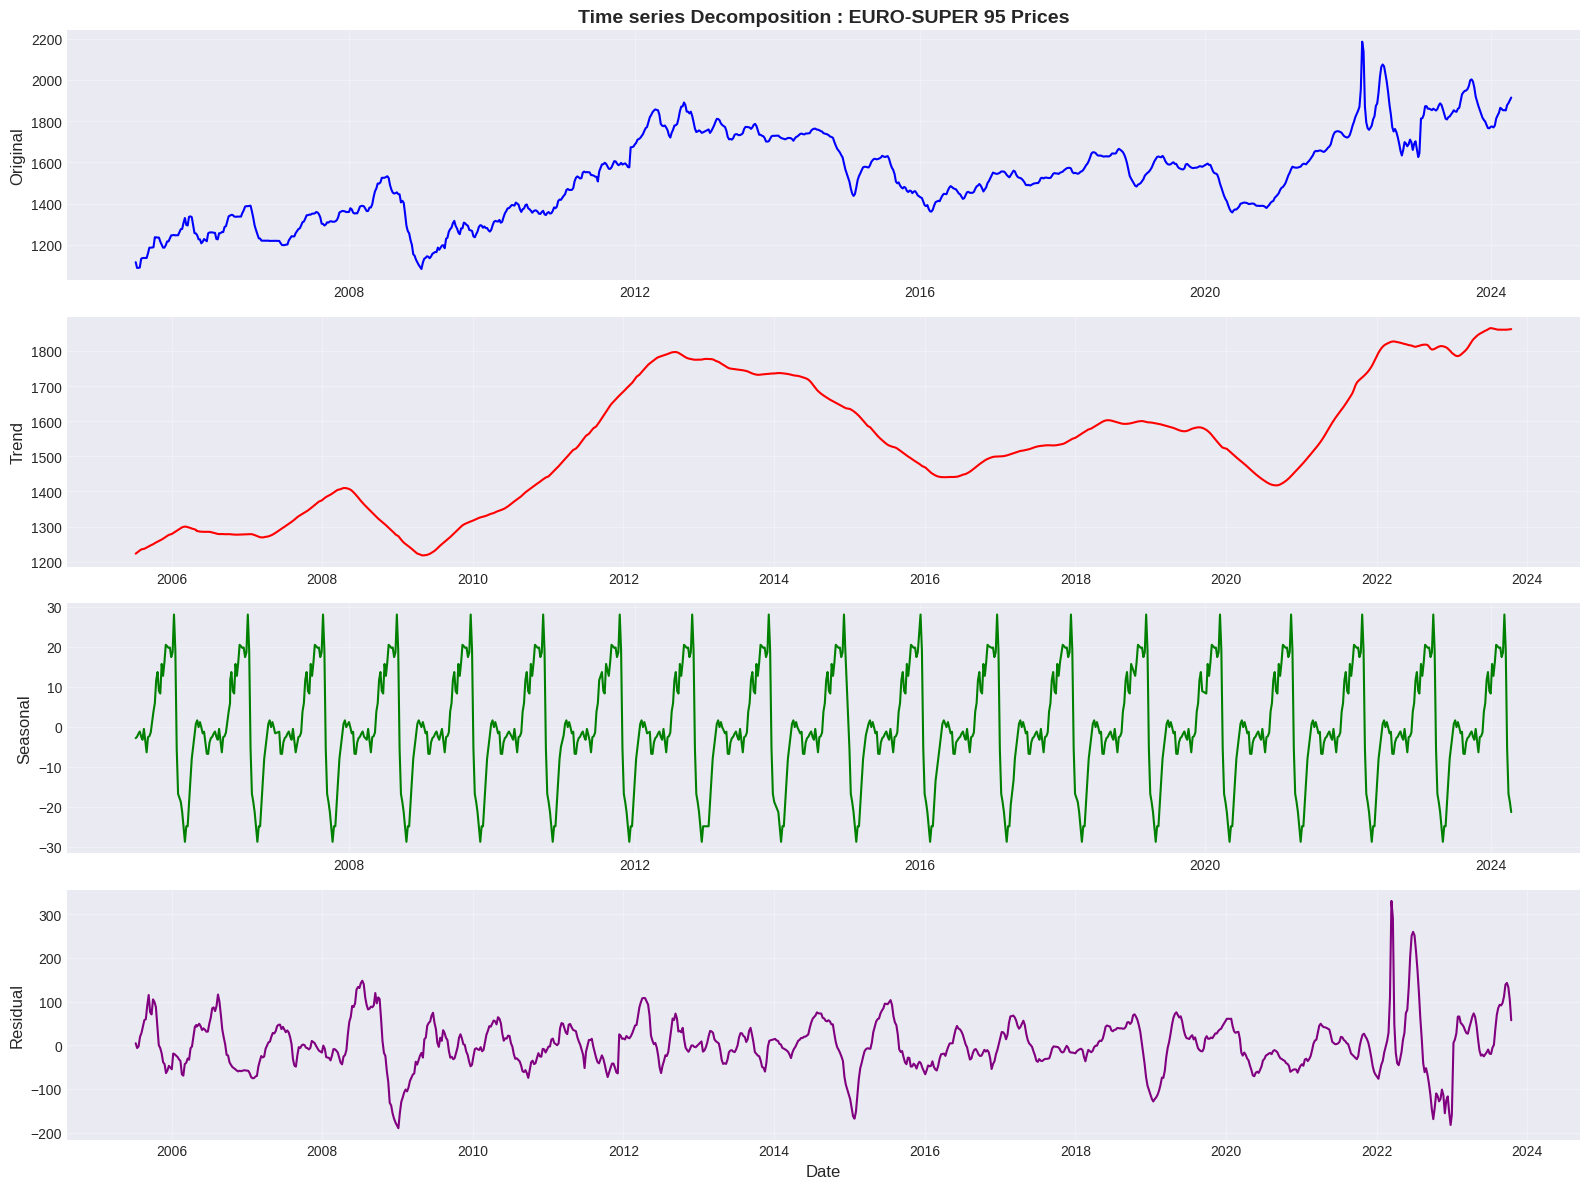

In [21]:
fig , axes = plt.subplots(4,1 , figsize = (16,12))

# original
axes[0].plot(fuel_df.index , fuel_df['Price'] , color = 'blue' , linewidth = 1.5)
axes[0].set_ylabel('Original' , fontsize = 12) # Corrected fontsize here
axes[0].set_title('Time series Decomposition : EURO-SUPER 95 Prices' , fontsize = 14 , fontweight = 'bold')
axes[0].grid(True , alpha = 0.3)

# Trend
axes[1].plot(decomposition.trend.index , decomposition.trend , color = 'red' , linewidth = 1.5)
axes[1].set_ylabel('Trend' , fontsize = 12)
axes[1].grid(True , alpha = 0.3)

# Seasonal
axes[2].plot(decomposition.seasonal.index , decomposition.seasonal , color = 'green' , linewidth
              = 1.5)
axes[2].set_ylabel('Seasonal' , fontsize = 12)
axes[2].grid(True , alpha = 0.3)

# residual
axes[3].plot(decomposition.resid.index, decomposition.resid, color='purple', linewidth=1.5)
axes[3].set_ylabel('Residual', fontsize=12)
axes[3].set_xlabel('Date', fontsize=12)
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### 3.3 Autocorrelation Analysis

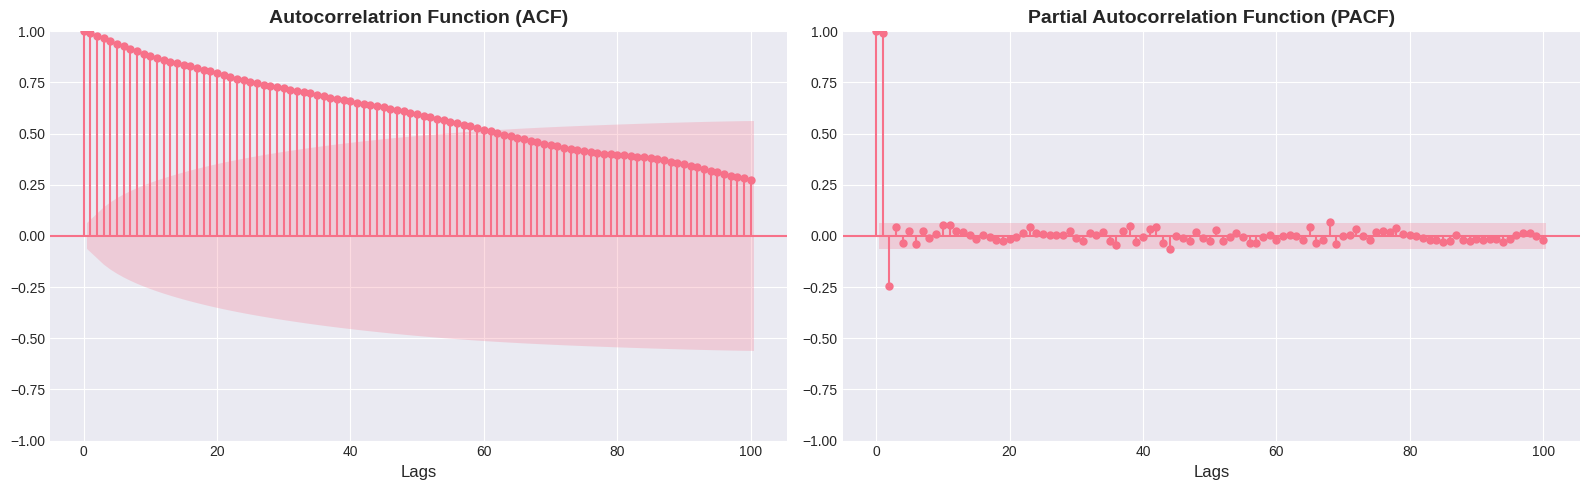

In [22]:
# plot ACF and PACF
fig , axes = plt.subplots(1,2 , figsize = (16, 5))

# ACF
plot_acf(fuel_df['Price'].dropna() , lags = 100 , ax = axes[0])
axes[0].set_title('Autocorrelatrion Function (ACF)' , fontsize = 14 , fontweight = 'bold')
axes[0].set_xlabel('Lags', fontsize = 12)

# PACF
plot_pacf(fuel_df['Price'].dropna() , lags = 100 , ax = axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)' , fontsize = 14 , fontweight = 'bold')
axes[1].set_xlabel('Lags', fontsize = 12)

plt.tight_layout()
plt.show()

### Step 4 : Feature Engineering

In [23]:
# creating a set of feature for time series forecast
def time_series_features(df):
    # Create time-based and lag features for time series forecasting
    df = df.copy()

    # Time-based features
    df['Year'] = df.index.year
    df['Month'] = df.index.month
    df['Quarter'] = df.index.quarter
    df['Week_of_Year'] = df.index.isocalendar().week
    df['Day_of_Year'] = df.index.dayofyear

    # Cyclical encoding for month (to capture seasonality)
    df['Month_Sin'] = np.sin(2 * np.pi * df['Month'] / 12)
    df['Month_Cos'] = np.cos(2 * np.pi * df['Month'] / 12)

    # Cyclical encoding for week
    df['Week_Sin'] = np.sin(2 * np.pi * df['Week_of_Year'] / 52)
    df['Week_Cos'] = np.cos(2 * np.pi * df['Week_of_Year'] / 52)

    # Lag features (previous weeks)
    for lag in [1, 2, 3, 4, 8, 12, 26, 52]:
        df[f'Lag_{lag}'] = df['Price'].shift(lag)

    # Rolling window features
    for window in [4, 8, 12, 26, 52]:
        df[f'Rolling_Mean_{window}'] = df['Price'].rolling(window=window).mean()
        df[f'Rolling_Std_{window}'] = df['Price'].rolling(window=window).std()
        df[f'Rolling_Min_{window}'] = df['Price'].rolling(window=window).min()
        df[f'Rolling_Max_{window}'] = df['Price'].rolling(window=window).max()

    # Exponential weighted moving average
    df['EWMA_12'] = df['Price'].ewm(span=12).mean()
    df['EWMA_26'] = df['Price'].ewm(span=26).mean()

    # Difference features (change from previous period)
    df['Diff_1'] = df['Price'].diff(1)
    df['Diff_4'] = df['Price'].diff(4)
    df['Diff_52'] = df['Price'].diff(52)

    # Percentage change
    df['Pct_Change_1'] = df['Price'].pct_change(1)
    df['Pct_Change_4'] = df['Price'].pct_change(4)

    return df

# Apply feature engineering
fuel_df_features = time_series_features(fuel_df)


In [25]:
print(f"\nTotal Features Created: {fuel_df_features.shape[1] - 1}")
print("\nFeature Names:")
print(fuel_df_features.columns.tolist())
print("\nDataset Shape after Feature Engineering:", fuel_df_features.shape)
print("\nFirst few rows with features:")
fuel_df_features.head(60)


Total Features Created: 44

Feature Names:
['Price', 'Year', 'Month', 'Quarter', 'Week_of_Year', 'Day_of_Year', 'Month_Sin', 'Month_Cos', 'Week_Sin', 'Week_Cos', 'Lag_1', 'Lag_2', 'Lag_3', 'Lag_4', 'Lag_8', 'Lag_12', 'Lag_26', 'Lag_52', 'Rolling_Mean_4', 'Rolling_Std_4', 'Rolling_Min_4', 'Rolling_Max_4', 'Rolling_Mean_8', 'Rolling_Std_8', 'Rolling_Min_8', 'Rolling_Max_8', 'Rolling_Mean_12', 'Rolling_Std_12', 'Rolling_Min_12', 'Rolling_Max_12', 'Rolling_Mean_26', 'Rolling_Std_26', 'Rolling_Min_26', 'Rolling_Max_26', 'Rolling_Mean_52', 'Rolling_Std_52', 'Rolling_Min_52', 'Rolling_Max_52', 'EWMA_12', 'EWMA_26', 'Diff_1', 'Diff_4', 'Diff_52', 'Pct_Change_1', 'Pct_Change_4']

Dataset Shape after Feature Engineering: (969, 45)

First few rows with features:


,Price,Year,Month,Quarter,Week_of_Year,Day_of_Year,Month_Sin,Month_Cos,Week_Sin,Week_Cos,...,Rolling_Std_52,Rolling_Min_52,Rolling_Max_52,EWMA_12,EWMA_26,Diff_1,Diff_4,Diff_52,Pct_Change_1,Pct_Change_4
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-03,1115.75,2005,1,1,1,3,5.000000e-01,8.660254e-01,0.120537,0.992709,...,NaN,NaN,NaN,1115.750000,1115.750000,NaN,NaN,NaN,NaN,NaN
2005-01-10,1088.00,2005,1,1,2,10,5.000000e-01,8.660254e-01,0.239316,0.970942,...,NaN,NaN,NaN,1100.718750,1101.341346,-27.75,NaN,NaN,-0.024871,NaN
2005-01-17,1088.14,2005,1,1,3,17,5.000000e-01,8.660254e-01,0.354605,0.935016,...,NaN,NaN,NaN,1095.809261,1096.598231,0.14,NaN,NaN,0.000129,NaN
2005-01-24,1090.01,2005,1,1,4,24,5.000000e-01,8.660254e-01,0.464723,0.885456,...,NaN,NaN,NaN,1093.978661,1094.756449,1.87,NaN,NaN,0.001719,NaN
2005-01-31,1132.11,2005,1,1,5,31,5.000000e-01,8.660254e-01,0.568065,0.822984,...,NaN,NaN,NaN,1104.338809,1103.418892,42.10,16.36,NaN,0.038623,0.014663
2005-02-07,1135.87,2005,2,1,6,38,8.660254e-01,5.000000e-01,0.663123,0.748511,...,NaN,NaN,NaN,1112.002548,1109.918590,3.76,47.87,NaN,0.003321,0.043998
2005-02-14,1135.88,2005,2,1,7,45,8.660254e-01,5.000000e-01,0.748511,0.663123,...,NaN,NaN,NaN,1117.330718,1114.535692,0.01,47.74,NaN,0.000009,0.043873
2005-02-21,1136.04,2005,2,1,8,52,8.660254e-01,5.000000e-01,0.822984,0.568065,...,NaN,NaN,NaN,1121.235056,1118.000569,0.16,46.03,NaN,0.000141,0.042229
2005-02-28,1136.04,2005,2,1,9,59,8.660254e-01,5.000000e-01,0.885456,0.464723,...,NaN,NaN,NaN,1124.164001,1120.674409,0.00,3.93,NaN,0.000000,0.003471


### Step 5 : Prepare Data for Machine Learning

In [26]:
# Remove rows with nan values (created by lag and rolling features)
fuel_df_clean = fuel_df_features.dropna()
fuel_df_features.shape

(969, 45)

In [27]:
# seperating features and target
x  = fuel_df_clean.drop('Price' , axis = 1)
y =  fuel_df_clean['Price']

In [28]:
x.shape

(917, 44)

In [29]:
y.shape

(917,)

In [40]:
# split data : use last 20 % as test set (time series split)
split_index = int(len(x) * 0.8)
x_train , x_test = x[:split_index] ,  x[split_index:]
y_train , y_test = y[:split_index] ,  y[split_index:]

In [41]:
x_train.shape[0]

733

In [42]:
x_test.shape[0]

184

In [43]:
print(f"Train date range : {x_train.index.min()} to { x_train.index.max()}")
print(f"\nTrain date range : {x_test.index.min()} to { x_test.index.max()}")

Train date range : 2006-01-23 00:00:00 to 2020-10-05 00:00:00

Train date range : 2020-10-12 00:00:00 to 2024-04-15 00:00:00


### Step 6 : Build Machine Learing Pipeline

In [47]:
# Define multiple models to compare
models = {
    'Ridge Regression': Ridge(random_state=42),
    'Lasso Regression': Lasso(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

# Store results
results = {}
predictions = {}

print("="*80)
print("TRAINING MACHINE LEARNING MODELS")
print("="*80)

for model_name, model in models.items():
    print(f"\n{'='*80}")
    print(f"Training: {model_name}")
    print(f"{'='*80}")

    # Create pipeline with scaling
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('model', model)
    ])

    # Train model
    pipeline.fit(x_train, y_train)

    # Predictions
    y_train_pred = pipeline.predict(x_train)
    y_test_pred = pipeline.predict(x_test)

    # Store predictions
    predictions[model_name] = {
        'train': y_train_pred,
        'test': y_test_pred
    }

    # Calculate metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    # Store results
    results[model_name] = {
        'Train RMSE': train_rmse,
        'Test RMSE': test_rmse,
        'Train MAE': train_mae,
        'Test MAE': test_mae,
        'Train R²': train_r2,
        'Test R²': test_r2,
        'pipeline': pipeline
    }

TRAINING MACHINE LEARNING MODELS

Training: Ridge Regression

Training: Lasso Regression

Training: Random Forest

Training: Gradient Boosting


In [48]:
# Print results
for model_name, metrics in results.items():
    print(f"\nPerformance Metrics for {model_name}:")
    print(f"  Training Set:")
    print(f"    RMSE: {metrics['Train RMSE']:.4f}")
    print(f"    MAE:  {metrics['Train MAE']:.4f}")
    print(f"    R²:   {metrics['Train R²']:.4f}")
    print(f"  Test Set:")
    print(f"    RMSE: {metrics['Test RMSE']:.4f}")
    print(f"    MAE:  {metrics['Test MAE']:.4f}")
    print(f"    R²:   {metrics['Test R²']:.4f}")


Performance Metrics for Ridge Regression:
  Training Set:
    RMSE: 1.5316
    MAE:  1.1047
    R²:   0.9999
  Test Set:
    RMSE: 5.7869
    MAE:  2.5584
    R²:   0.9987

Performance Metrics for Lasso Regression:
  Training Set:
    RMSE: 1.4712
    MAE:  1.1372
    R²:   0.9999
  Test Set:
    RMSE: 3.5128
    MAE:  2.2970
    R²:   0.9995

Performance Metrics for Random Forest:
  Training Set:
    RMSE: 3.3422
    MAE:  2.1934
    R²:   0.9996
  Test Set:
    RMSE: 63.8170
    MAE:  37.0325
    R²:   0.8478

Performance Metrics for Gradient Boosting:
  Training Set:
    RMSE: 2.4425
    MAE:  1.9159
    R²:   0.9998
  Test Set:
    RMSE: 53.6257
    MAE:  26.7135
    R²:   0.8926


In [49]:
# Create comparison dataframe
results_df = pd.DataFrame(results).T
print("\n" + "="*80)
print("MODEL COMPARISON SUMMARY")
print("="*80)
results_df


MODEL COMPARISON SUMMARY


,Train RMSE,Test RMSE,Train MAE,Test MAE,Train R²,Test R²,pipeline
Ridge Regression,1.531618,5.786912,1.104714,2.558417,0.999923,0.998749,"(StandardScaler(), Ridge(random_state=42))"
Lasso Regression,1.471176,3.512757,1.137226,2.296971,0.999929,0.999539,"(StandardScaler(), Lasso(random_state=42))"
Random Forest,3.342227,63.816964,2.193425,37.032463,0.999635,0.847838,"(StandardScaler(), (DecisionTreeRegressor(max_..."
Gradient Boosting,2.442494,53.62574,1.915891,26.713454,0.999805,0.892557,"(StandardScaler(), ([DecisionTreeRegressor(cri..."


### Step 7 : Hyperparameter Tuning (Best Model )

In [51]:
# select the best model based on test RMSE
best_model_name = results_df['Test RMSE'].idxmin()
print(f"\nBest Model: {best_model_name}")


Best Model: Lasso Regression


In [52]:
# Define the Lasso pipeline
lasso_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model', Lasso(random_state=42, max_iter=1000))  # Increased max_iter for convergence
])

# Parameter grid for Lasso - focus on alpha (regularization strength)
# Smaller alpha = less regularization, larger alpha = more regularization (towards 0 coefficients)
param_grid_lasso = {
    'model__alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],  # Wide range to test sparsity
    'model__max_iter': [1000, 2000, 5000]  # Ensure convergence for different alphas
}

print("Performing Hyperparameter Tuning on Lasso Regression...")
print(f"Parameter Grid Size: {len(param_grid_lasso['model__alpha']) * len(param_grid_lasso['model__max_iter'])} combinations")

# Time series cross-validation (5 splits to respect temporal order)
tscv = TimeSeriesSplit(n_splits=5)

# Grid search with RMSE as the scoring metric (negative for minimization)
grid_search_lasso = GridSearchCV(
    lasso_pipeline,
    param_grid_lasso,
    cv=tscv,
    scoring='neg_mean_squared_error',  # We'll take sqrt later for RMSE
    n_jobs=-1,  # Use all CPU cores
    verbose=1,  # Show progress
    return_train_score=True
)

# Fit the grid search on training data
grid_search_lasso.fit(x_train, y_train)

Performing Hyperparameter Tuning on Lasso Regression...
Parameter Grid Size: 18 combinations
Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', Lasso(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],
                         'model__max_iter': [1000, 2000, 5000]},
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

In [53]:
# Extract best parameters and score
best_params_lasso = grid_search_lasso.best_params_
best_score_lasso = np.sqrt(-grid_search_lasso.best_score_)  # Convert back to RMSE

print(f"\nBest Parameters for Lasso: {best_params_lasso}")
print(f"Best Cross-Validation RMSE: {best_score_lasso:.4f}")


Best Parameters for Lasso: {'model__alpha': 0.01, 'model__max_iter': 1000}
Best Cross-Validation RMSE: 0.1478


In [54]:
# Use the best estimator for final evaluation
best_lasso_pipeline = grid_search_lasso.best_estimator_

# Predictions on train and test sets
y_train_pred_lasso = best_lasso_pipeline.predict(x_train)
y_test_pred_lasso = best_lasso_pipeline.predict(x_test)

In [55]:
# Calculate final metrics
train_rmse_lasso = np.sqrt(mean_squared_error(y_train, y_train_pred_lasso))
test_rmse_lasso = np.sqrt(mean_squared_error(y_test, y_test_pred_lasso))
train_mae_lasso = mean_absolute_error(y_train, y_train_pred_lasso)
test_mae_lasso = mean_absolute_error(y_test, y_test_pred_lasso)
train_r2_lasso = r2_score(y_train, y_train_pred_lasso)
test_r2_lasso = r2_score(y_test, y_test_pred_lasso)

In [56]:
# Display tuned performance
print("\n" + "="*60)
print("TUNED LASSO REGRESSION PERFORMANCE")
print("="*60)
print(f"Training Set:")
print(f"  RMSE: {train_rmse_lasso:.4f}")
print(f"  MAE:  {train_mae_lasso:.4f}")
print(f"  R²:   {train_r2_lasso:.4f}")
print(f"Test Set:")
print(f"  RMSE: {test_rmse_lasso:.4f}")
print(f"  MAE:  {test_mae_lasso:.4f}")
print(f"  R²:   {test_r2_lasso:.4f}")

# Compare to untuned Lasso (from earlier results)
untuned_lasso_rmse = results['Lasso Regression']['Test RMSE']
improvement = ((untuned_lasso_rmse - test_rmse_lasso) / untuned_lasso_rmse) * 100
print(f"\nImprovement in Test RMSE: {improvement:.2f}% (from {untuned_lasso_rmse:.4f} to {test_rmse_lasso:.4f})")


TUNED LASSO REGRESSION PERFORMANCE
Training Set:
  RMSE: 0.0641
  MAE:  0.0491
  R²:   1.0000
Test Set:
  RMSE: 0.2159
  MAE:  0.1181
  R²:   1.0000

Improvement in Test RMSE: 93.85% (from 3.5128 to 0.2159)


### Step 8 : Feature importance Analysis


TOP 20 MOST IMPORTANT FEATURES (Absolute Coefficients) - Lasso Regression
            Feature  Importance
9             Lag_1  174.131921
39           Diff_1   13.312514
37          EWMA_12    0.861412
42     Pct_Change_1    0.217699
33  Rolling_Mean_52    0.116317
19    Rolling_Min_4    0.113378
43     Pct_Change_4    0.085777
40           Diff_4    0.037040
6         Month_Cos    0.007782
7          Week_Sin    0.000690
8          Week_Cos    0.000203
3      Week_of_Year    0.000000
11            Lag_3    0.000000
10            Lag_2    0.000000
5         Month_Sin    0.000000
4       Day_of_Year    0.000000
0              Year    0.000000
1             Month    0.000000
2           Quarter    0.000000
12            Lag_4    0.000000


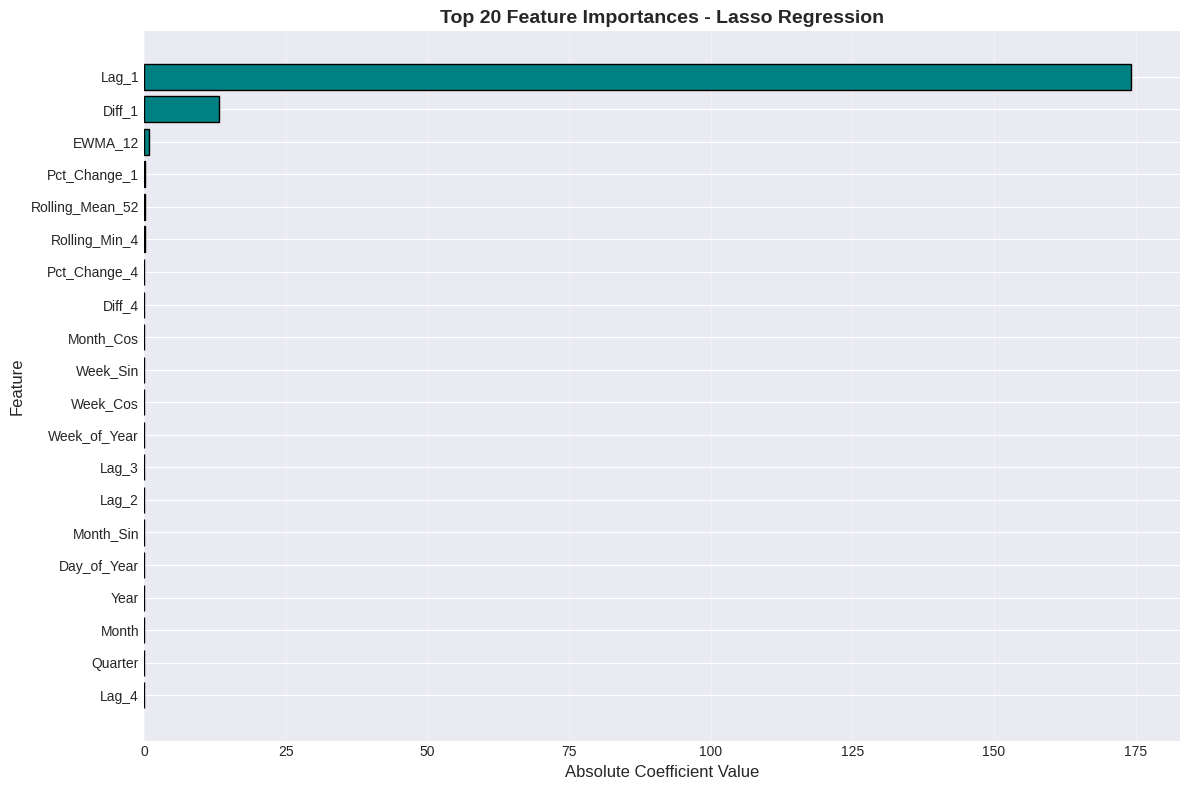

In [59]:
# Feature importance for linear models (Lasso Regression)
if best_model_name in ['Ridge Regression', 'Lasso Regression']:
    # Extract the model from the pipeline
    best_model = best_lasso_pipeline.named_steps['model']

    # Get coefficients
    coefficients = best_model.coef_
    feature_names = x_train.columns

    # Create dataframe
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': np.abs(coefficients) # Use absolute coefficients for linear models
    }).sort_values('Importance', ascending=False)

    print("\n" + "="*80)
    print(f"TOP 20 MOST IMPORTANT FEATURES (Absolute Coefficients) - {best_model_name}")
    print("="*80)
    print(feature_importance_df.head(20))

    # Plot feature importance
    plt.figure(figsize=(12, 8))
    top_features = feature_importance_df.head(20)
    plt.barh(top_features['Feature'], top_features['Importance'], color='teal', edgecolor='black')
    plt.xlabel('Absolute Coefficient Value', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.title(f'Top 20 Feature Importances - {best_model_name}', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()

elif best_model_name in ['Random Forest', 'Gradient Boosting']:
    # Extract the model from pipeline
    best_model = results[best_model_name]['pipeline'].named_steps['model']

    # Get feature importances
    importances = best_model.feature_importances_
    feature_names = x_train.columns

    # Create dataframe
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)

    print("\n" + "="*80)
    print(f"TOP 20 MOST IMPORTANT FEATURES - {best_model_name}")
    print("="*80)
    print(feature_importance_df.head(20))

    # Plot feature importance
    plt.figure(figsize=(12, 8))
    top_features = feature_importance_df.head(20)
    plt.barh(top_features['Feature'], top_features['Importance'], color='teal', edgecolor='black')
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.title(f'Top 20 Feature Importances - {best_model_name}', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()

else:
    print(f"Feature importance visualization is not directly supported for {best_model_name}.")

### Step 9 : Forecast Future Price


FORECASTED EURO-SUPER 95 PRICES FOR THE NEXT 52 WEEKS
            Forecasted_Price
2024-04-28       1912.224577
2024-05-05       1390.655700
2024-05-12       1390.632663
2024-05-19       1390.610999
2024-05-26       1390.610928


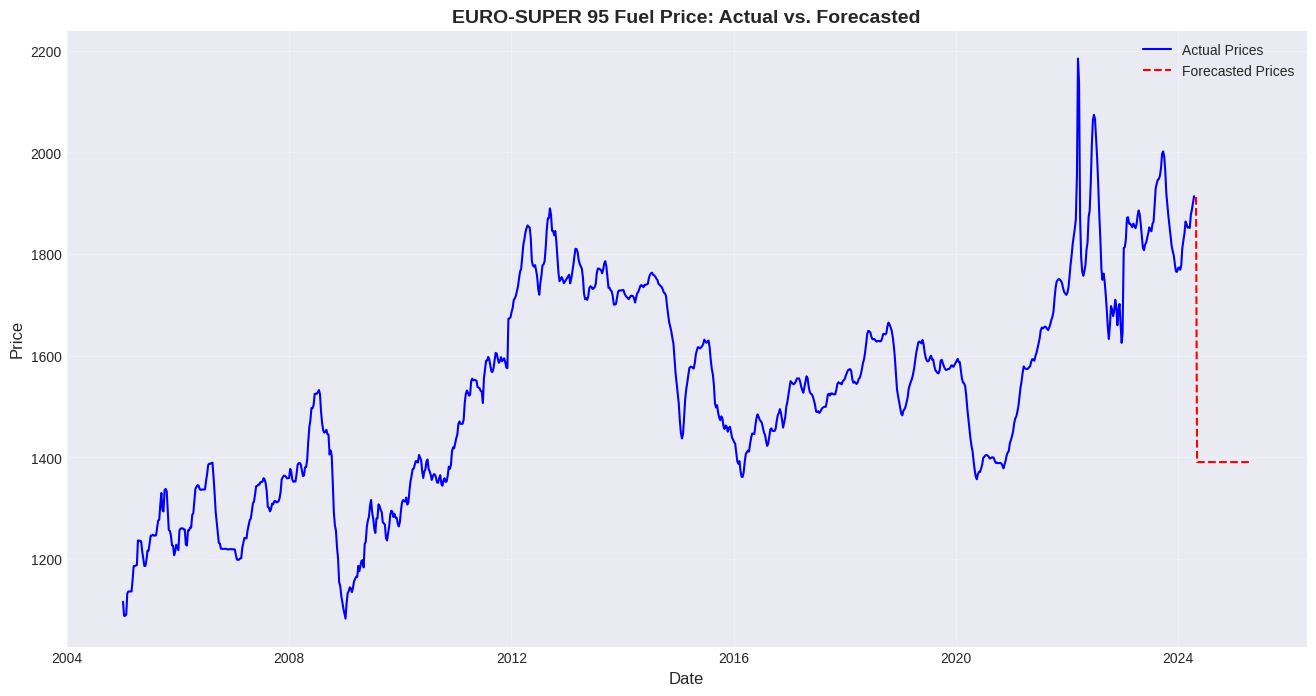

In [61]:
# Determine the last date in the dataset
last_date = fuel_df.index.max()

# Define the number of periods to forecast (e.g., next 52 weeks or 1 year)
forecast_periods = 52

# Create a range of future dates starting from the day after the last date
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=7), periods=forecast_periods, freq='W')

# Create a DataFrame for future dates
future_df = pd.DataFrame(index=future_dates)

# Combine with the original data to generate features, dropping the original 'Price'
# We need to combine to ensure features like lags and rolling windows can be calculated
combined_df = pd.concat([fuel_df, future_df])

# Apply the feature engineering function to the combined DataFrame
combined_df_features = time_series_features(combined_df)

# Separate the future data with generated features
future_features = combined_df_features.loc[future_dates].drop('Price', axis=1)

# Ensure the order of columns in future_features matches x_train
future_features = future_features[x_train.columns]

# Fill NaN values in future_features with the last known values from the training data
# This is a common approach for forecasting when lag/rolling features extend beyond known data
last_known_values = x_train.iloc[-1]
future_features = future_features.fillna(last_known_values)


# Make predictions using the best trained model
future_predictions = best_lasso_pipeline.predict(future_features)

# Create a DataFrame for the future predictions
future_predictions_df = pd.DataFrame(future_predictions, index=future_dates, columns=['Forecasted_Price'])

print("\n" + "="*80)
print(f"FORECASTED EURO-SUPER 95 PRICES FOR THE NEXT {forecast_periods} WEEKS")
print("="*80)
print(future_predictions_df.head())

# Visualize the actual vs. forecasted prices
plt.figure(figsize=(16, 8))
plt.plot(fuel_df.index, fuel_df['Price'], label='Actual Prices', color='blue', linewidth=1.5)
plt.plot(future_predictions_df.index, future_predictions_df['Forecasted_Price'], label='Forecasted Prices', color='red', linestyle='--', linewidth=1.5)
plt.title('EURO-SUPER 95 Fuel Price: Actual vs. Forecasted', fontsize=14, fontweight='bold')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Step 10 : Saving The model using Pickle

In [64]:
import pickle

# Define the filename for the saved model
model_filename = 'best_lasso_pipeline.pkl'

# Save the trained pipeline to a file
with open(model_filename, 'wb') as file:
    pickle.dump(best_lasso_pipeline, file)

print(f"Model saved successfully to {model_filename}")

Model saved successfully to best_lasso_pipeline.pkl
